# Benchmarking Our Algorithm against others

In [1]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from time import time
from tqdm import trange
import pickle as pkl

bloating_r = 0.5
vmax = 1.0

n_agents = list(range(1,21))

# Algorithms
algs = {"S2M2": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Simple_MILP_Planning")[0],
        "PBS_Tube": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Tube_Planning")[0],
        "TAHP": lambda hg: TAHP(hg,vmax=vmax,bloating_r=bloating_r)}
results = []

env_name = "MultiTunnel"


# Execution timeout handling
import signal
# Register an handler for the timeout
def timeout_handler(signum, frame):
    print("Execution Time Out")
    raise Exception("end of time")
 


# Experiments
for i in range(len(n_agents)):
    N = n_agents[i]
    env = MultiTunnelEnv(n_tunnel = 4, tunnel_width = bloating_r*2.5, N_agent = N)
    HG = HybridGraph(env,bloating_r)

    for name,alg in algs.items():
        print("Alg:", name, "N agent:",N)
        # Register the signal function handler
        signal.signal(signal.SIGALRM, timeout_handler)
        TIMEOUT = 120 # 2 minute timeout
        signal.alarm(TIMEOUT)

        try:
            result = {}
            
            t0 = time()
            plan = alg(HG)
            t = time()-t0

            result['plan'] = plan
            result['time'] = t
            result['N_agent'] = N
            result['alg_name'] = name

            results.append(result)
        except Exception:
            print("Time out for algorithm", name, "N agent = ", N)
        finally:
            # Reset the timeout handler.
            signal.alarm(0)
        
        

        # Save checkpoint data
        with open("./data/{}.pkl".format(env_name),'wb') as fp:
            pkl.dump(results,fp)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-15


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


KeyboardInterrupt: 

In [ ]:
# Visualize the simulation results
metrics = {"Makespan": lambda result: makespan(result['plan']),
           "Flowtime": lambda result: flowtime(result['plan']),
           "Throuput per 60s": lambda result: result['N_agent']/makespan(result['plan']) * 60,
           "Ave. Travel Cost": lambda result: flowtime(result['plan'])/result['N_agent'],
           "Compute Time": lambda result: result['time']}

performance = {}

for result in results:
    alg = result['alg_name']
    if alg not in performance:
        performance[alg] = {}
        performance[alg]['n_agents'] = []
    
    performance[alg]['n_agents'].append(result['N_agent'])

    for metric, eval in metrics.items():
        if metric not in performance[alg]:
            performance[alg][metric] = []
        
        performance[alg][metric].append(eval(result))

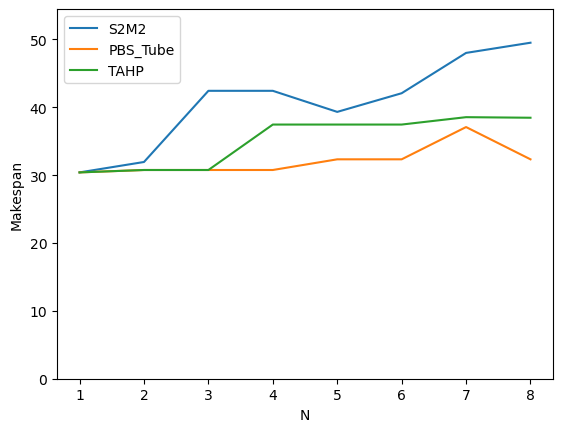

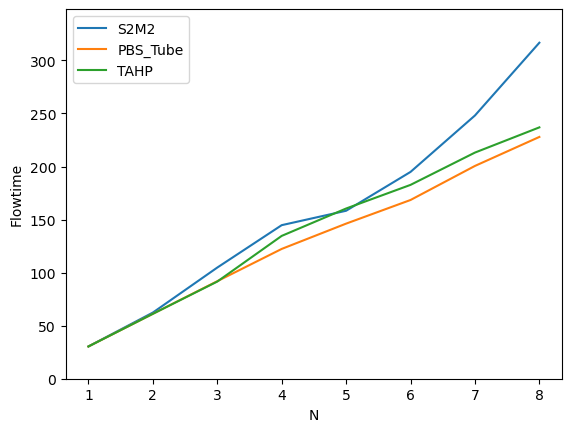

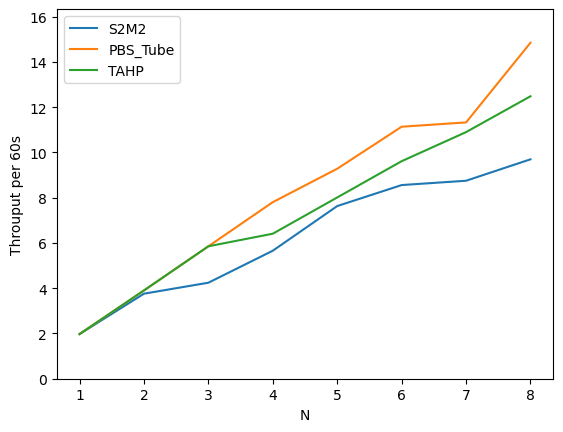

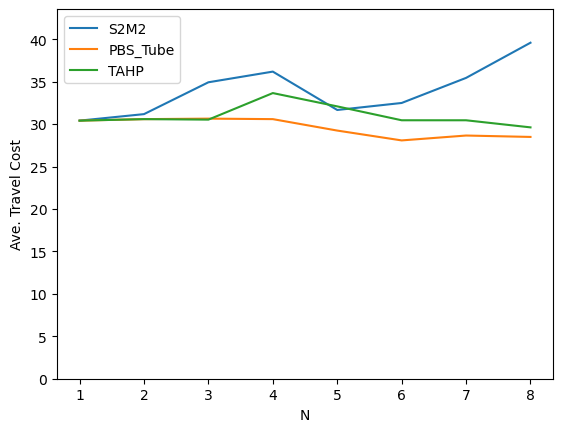

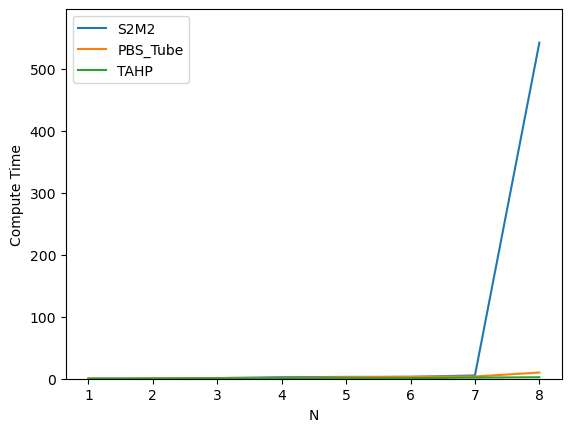

In [ ]:
from matplotlib import pyplot as plt

for metric in metrics:
    plt.figure()
    plt.ylabel(metric)
    plt.xlabel("N")
    # plt.ylim((0,20))
    ymax = 0
    for alg in performance:
        plt.plot(performance[alg]['n_agents'],performance[alg][metric],label = alg)
        ymax = max(ymax,max(performance[alg][metric]))
    plt.ylim(0.0,ymax*1.1)
    plt.legend()
    plt.show()